## Importing libaries and getting DataFrame

In [79]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [80]:
import glob
x=glob.glob("../data/*.root")
p=[xs[8:] for xs in x]
x[1][8:]

'data15_13TeV.00267358.physics_MinBias.30062015_v0_per_1.root'

In [81]:
p

['data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root',
 'data15_13TeV.00267358.physics_MinBias.30062015_v0_per_1.root',
 'mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root',
 'mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_1.root']

In [82]:
path = "../data/"+p[0]

In [83]:
file = uproot.open(path)
T = file['tree']
df = T.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" "))

## Making plots to look at the data

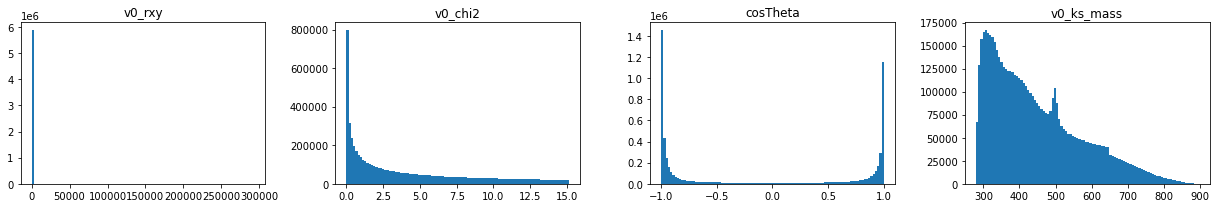

In [84]:
fig, ax = plt.subplots(ncols = 4, figsize = (17, 3))
bins = 100

# fig.suptitle("Hist of all data")

for i, col in enumerate(df.columns):
    ax[i].set_title(col)
    ax[i].hist(df[col], bins = bins)

fig.tight_layout()

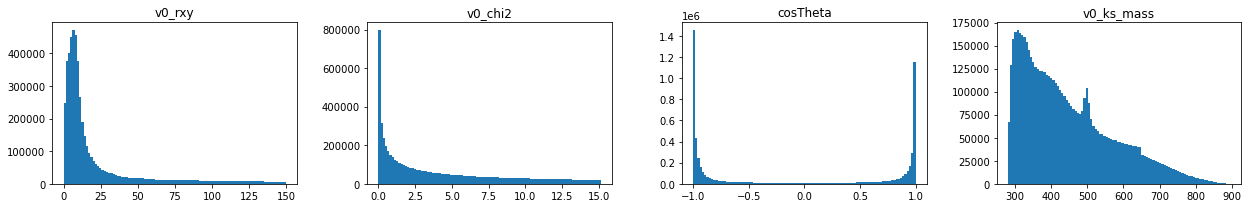

In [85]:
# Restrict v0_rxy to less than 150
cut_rxy = 150
df = df.loc[df["v0_rxy"] < cut_rxy]
ax[0].clear()
ax[0].set_title("v0_rxy")
ax[0].hist(df["v0_rxy"], bins = bins)


#Draw plot
fig

## Making cuts

We now make cuts for each variable

### v0_rxy
It is clear that we need to restrict to low values. Lets take a look at v0_rxy for < 150

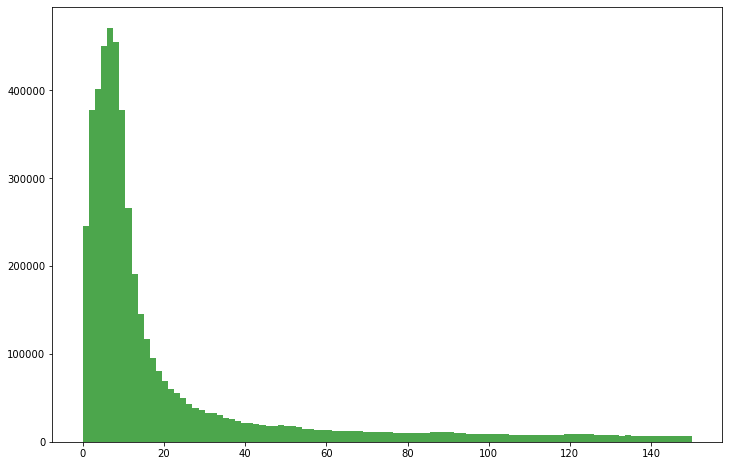

In [86]:
fig, ax = plt.subplots(figsize = (12, 8))
# ax.hist(df['v0_rxy'].loc[df['trueKs'] == 0], bins = 100, range = (0, 100), color = "red");
ax.hist(df['v0_rxy'], bins = 100, range = (0, 150), color = "green", alpha = 0.7);

We choose to cut between 2 and 130

In [87]:
df = df.loc[np.logical_and(df['v0_rxy'] < 130, df['v0_rxy'] > 2)]

### Chi2

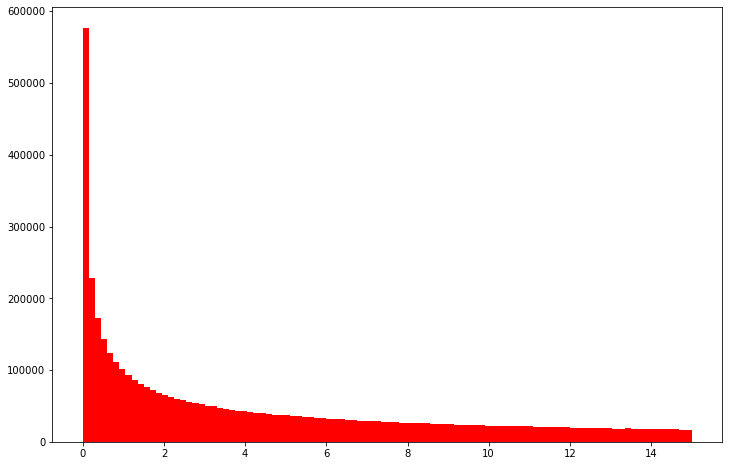

In [88]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.hist(df['v0_chi2'], bins = 100, range = (0, 15), color = "red");

We cut at 3.5 and up

In [89]:
df = df.loc[df['v0_chi2'] < 3.5]

### CosTheta

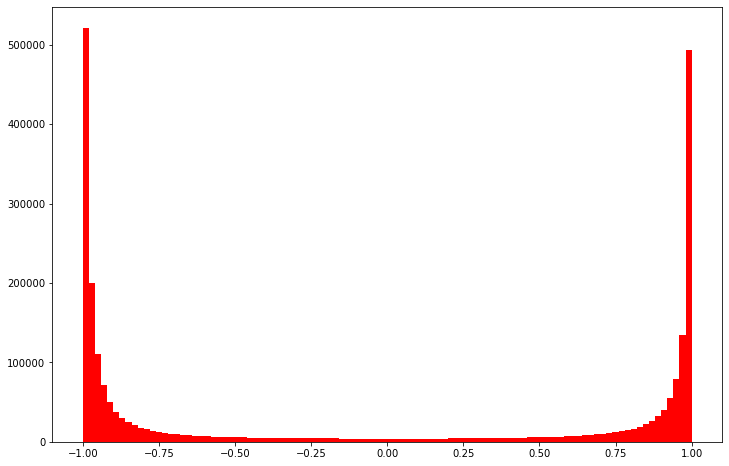

In [90]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.hist(df['cosTheta'], bins = 100, range = (-1, 1), color = "red");

Set cut at 0.9995

In [91]:
df = df.loc[df['cosTheta'] > 0.9995]

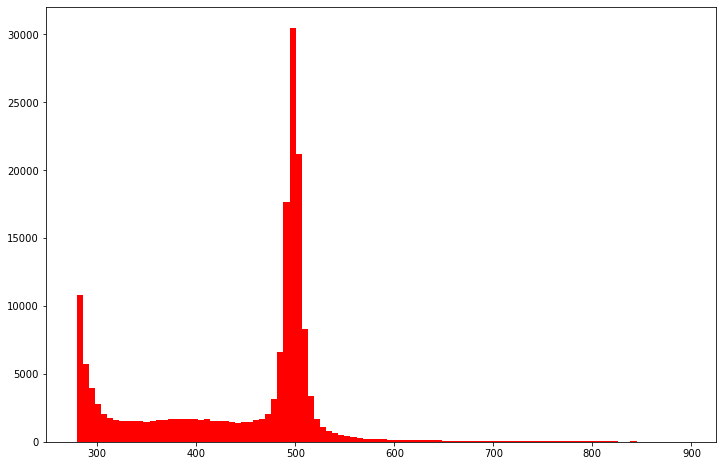

In [92]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.hist(df['v0_ks_mass'], bins = 100, color = "red");

Check if we make a 4 sigma cut, so 498.68 +/- 12.4

In [93]:
std=12.4
# df = df.loc[abs(df['v0_ks_mass'] - 498.68) < 4 * std]

In [96]:
df=df.loc[abs(df['v0_ks_mass']-500)<100]

## Try plot after cuts

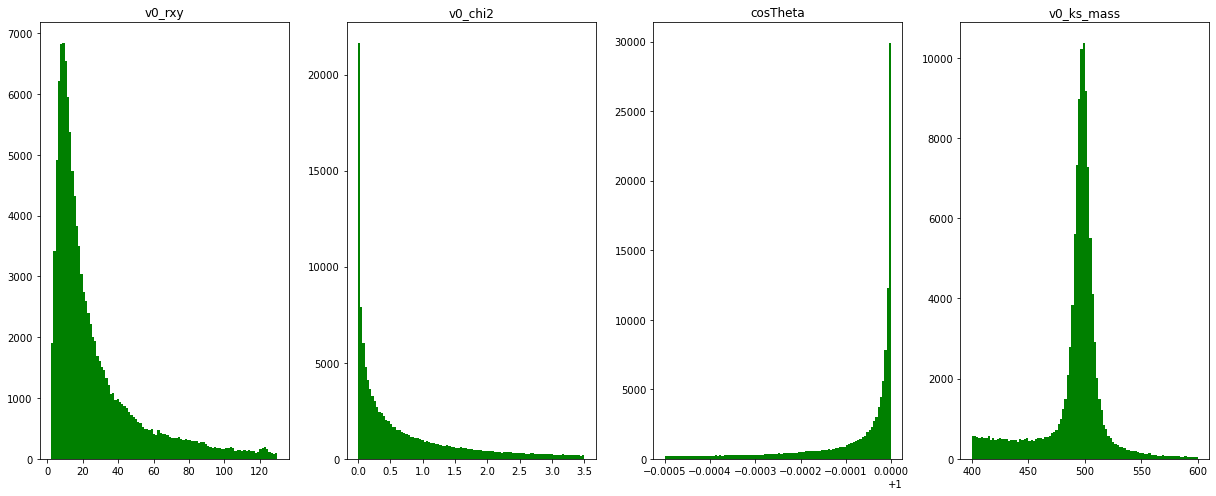

In [97]:
fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (17, 7))

plot_values = "v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" ") # Values to plot 

for i, col in enumerate(plot_values):
    ax[i].set_title(col)
    ax[i].hist(df[col], bins = bins, color = "green")

fig.tight_layout()

In [98]:
mass=df['v0_ks_mass'].to_numpy()

In [99]:
from iminuit import Minuit
import sys

In [100]:
sys.path.append('../../../2YR-UNI/Blok2/AppStat2019/External_Functions')
import matplotlib as mpl
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure
from scipy import stats

In [187]:
counts, bin_edges=np.histogram(mass, bins=300)
binwidth=bin_edges[1]-bin_edges[0]
xl=bin_edges[1:]-1/2*binwidth

In [194]:
mask1, mask2=xl>480, xl<520
mask=mask1&mask2

In [195]:
def lin(x, a, b, c):
    x=x-400
    return c+b*x+a*x**2
chi2reg1 = Chi2Regression(lin, xl[~mask], counts[~mask], np.sqrt(counts)[~mask])
minuit_obj = Minuit(chi2reg1, pedantic=0, print_level=1, a=0.1, b=-1, c=700)
minuit_obj.migrad()

if (not minuit_obj.get_fmin().is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

# mu, sig, A, C, r2 = minuit_obj.args
a, b, c= minuit_obj.args
Chi2 = minuit_obj.fval
Ndof = len(xl[~mask])-len(minuit_obj.args)
ProbChi2 = stats.chi2.sf(Chi2, Ndof)
ProbChi2, a, b, c

------------------------------------------------------------------
| FCN = 2091                    |     Ncalls=139 (145 total)     |
| EDM = 0.00122 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


(1.4706478628882767e-293,
 -0.0021964521274072443,
 -0.5366958454904125,
 191.91181619619675)

In [196]:
#this is actually a double gauss, fixed sigma ratios
def gauss(x, mu, sig, A, A2):
    return binwidth*A*np.exp(-(x-mu)**2/(2*sig**2))+binwidth*A2*np.exp(-(x-mu)**2/(8*sig**2))+lin(x, a,b,c)

In [201]:
chi2reg1 = Chi2Regression(gauss, xl, counts, np.sqrt(counts))
minuit_obj = Minuit(chi2reg1, pedantic=0, print_level=1, mu=498, sig=6, A=10000,A2=3000)
minuit_obj.migrad()f


if (not minuit_obj.get_fmin().is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

# mu, sig, A, C, r2 = minuit_obj.args
mu, sig, A, A2= minuit_obj.args
Chi2 = minuit_obj.fval
Ndof = len(xl)-len(minuit_obj.args)
ProbChi2 = stats.chi2.sf(Chi2, Ndof)
ProbChi2, mu, sig, A, A2

------------------------------------------------------------------
| FCN = 928.1                   |     Ncalls=208 (211 total)     |
| EDM = 0.000716 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------


(2.4125419859122803e-66,
 498.05851599872614,
 5.446119718919988,
 3629.2339747477436,
 1296.2734502085862)

In [202]:
minuit_obj.migrad()

------------------------------------------------------------------
| FCN = 928.1                   |     Ncalls=102 (320 total)     |
| EDM = 0.00163 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


------------------------------------------------------------------
| FCN = 928.1                   |     Ncalls=102 (320 total)     |
| EDM = 0.00163 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | mu   |  498.059  |   0.021   |            |            |         |         |       |
| 1 | sig  |   5.446   |   0.009   |            |            |         |         |       |
| 2 | A    |  0.363E4  |  0.002E4  |            |            |         |         |       |
| 3 | A2   |   1296    |    12     |            |            |         |         |       |
------------------------------------------------------------------------------------------

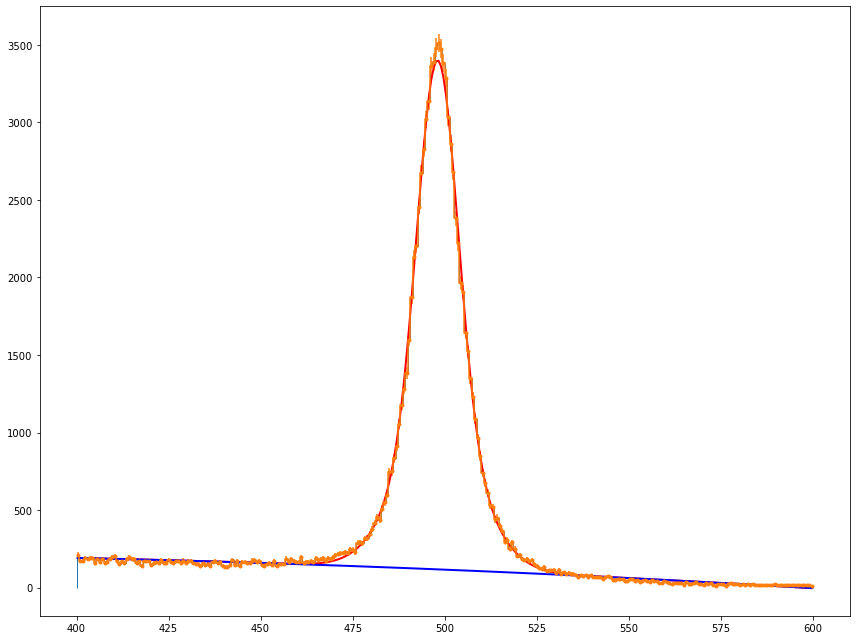

In [203]:
fig, ax=plt.subplots(figsize=(12,9))
ax.hist(mass, bins=300, histtype='step')
ax.plot(xl, gauss(xl,mu, sig, A, A2), 'r', linewidth=2.0, label='Bad fitting function')
ax.plot(xl, lin(xl,a,b,c), 'b', linewidth=2.0, label='linear background')
ax.errorbar(xl,counts,yerr=np.sqrt(counts),marker = '.',drawstyle = 'steps-mid')

# d = {'Entries'   : "{:d}".format(sum(counts)),
#      'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2, Ndof),
#      'Prob'      : "{:.3f}".format(ProbChi2),
#      'N1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N1'], minuit_obj.errors['N1']),
#      'N2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N2'], minuit_obj.errors['N2']),
#      'r1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r1'], minuit_obj.errors['r1']),
#      'r2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r2'], minuit_obj.errors['r2'])}

# ax.text(0.65, 0.95, nice_string_output(d, 0), family='monospace', 
#         transform=ax.transAxes, fontsize=13, color='red', verticalalignment='top')
fig.tight_layout()

In [ ]:
#notice that there probaly are more than two sigma bands that are relevant